- Check for Colab Env
> if we are in colab env we need to get the data + scripts from github or somewhere

In [ ]:
import os
if "COLAB_GPU" in os.environ:
    _useMultiProcessing = False
    os.system("git clone https://github.com/zaxo7/UNet-Playground.git")
    os.chdir("/content/UNet-Playground/")
else:
    _useMultiProcessing = True
    
if "PAPERSPACE_FQDN" in os.environ:
    !apt update
    !apt install libgl1 -y
    !pip install opencv-python
    !pip install scikit-image
    !pip install imutils
    #!git pull


- enable module autoreload and fix an import bug

In [3]:
%load_ext autoreload
%autoreload 2

import sys,os
sys.path.append(os.getcwd() + '/scripts')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- import the scripts and data

In [4]:
from scripts import data, model
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from DataGenerator import DataGenerator

- load the model and compile it

In [4]:
_model_name = "WBC_binaryCrossEntrophy_no_noise_15"

In [ ]:
objects = {
    "tversky_loss":model.tversky_loss,
    "mean_iou": model.mean_iou,
    "dsc":model.dsc,
    "tversky":model.tversky,
    "tversky_b":model.tversky_b,
    "acc": tf.keras.metrics.Accuracy,
    "tversky_loss_b": model.tversky_loss_b
}


unet = tf.keras.models.load_model(f'./models/{_model_name}', custom_objects=objects)

unet.compile(optimizer="adam",
             loss="BinaryCrossentropy",
             metrics=[model.mean_iou, model.dsc, model.tversky, model.tversky_b, 'acc'])

#unet.summary()

- load the training log 

In [5]:
#save the training log into a file
import json

# Opening JSON file
with open(f"models/{_model_name}_log.json") as fp:
    # returns JSON object as
    # a dictionary
    loaded_hist = json.load(fp)

- predict full image

In [6]:
images_path = sorted(glob.glob(f'ALL-IDB1/*.jpg'))[:5]

In [ ]:
images, masks = model.predictFullImage(unet,
                          data.load_data_na(images_path, RGB=True, clahe=True),
                        padding=100,
                        input_size=188,
                        output_size=100,
                        normalize_output = False,
                        edge=False)

In [39]:
import cv2
i = 0
for mask in masks:
    filename = images_path[i].split("/")[-1]
    cv2.imwrite(f"outputs_WBC/masks/{filename}", mask * 255.0)
    i += 1


- CCL

17

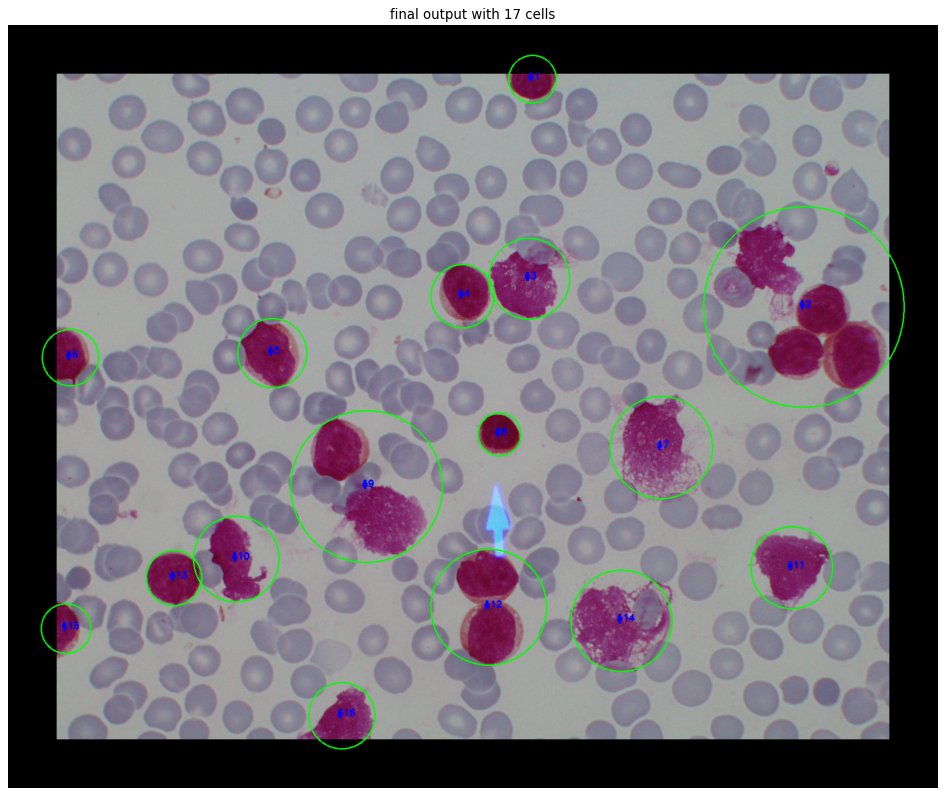

In [8]:
from scripts import postProcessing

original_images = data.load_data_na(images_path, RGB=True, preprocess = True, padding=100)

ind = 1

postProcessing.CCL_Count(original_images[ind], masks[ind], plot=False, min_filter_size=1000)

- Circle Hough Transform

found 37 circles before cleaning
found 20 circles after cleaning


20

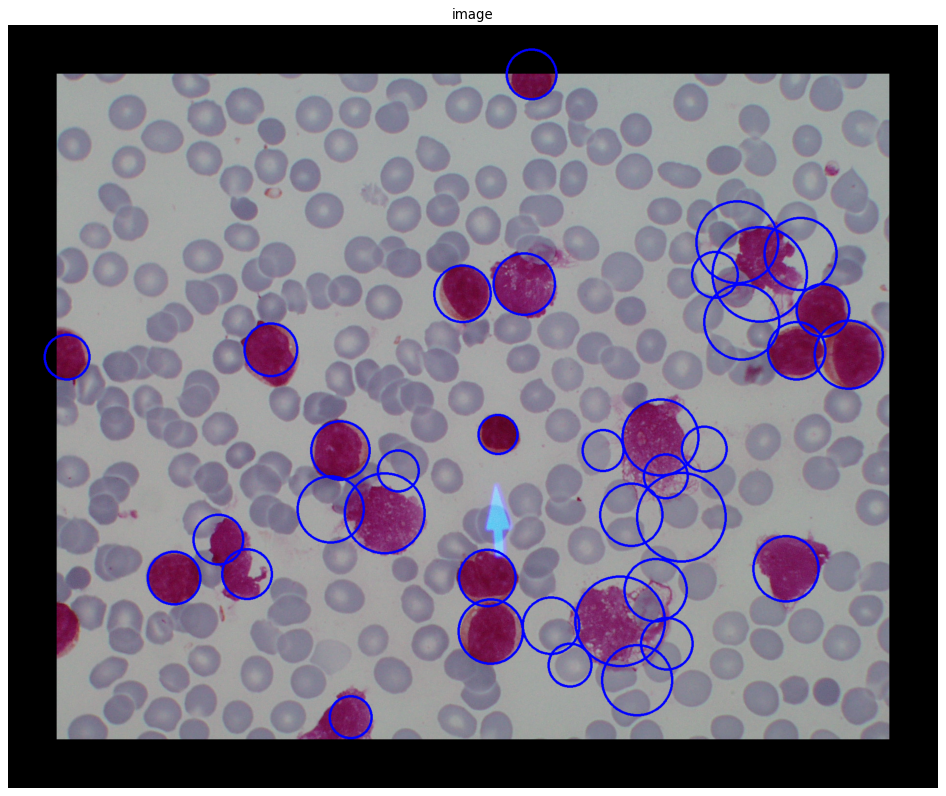

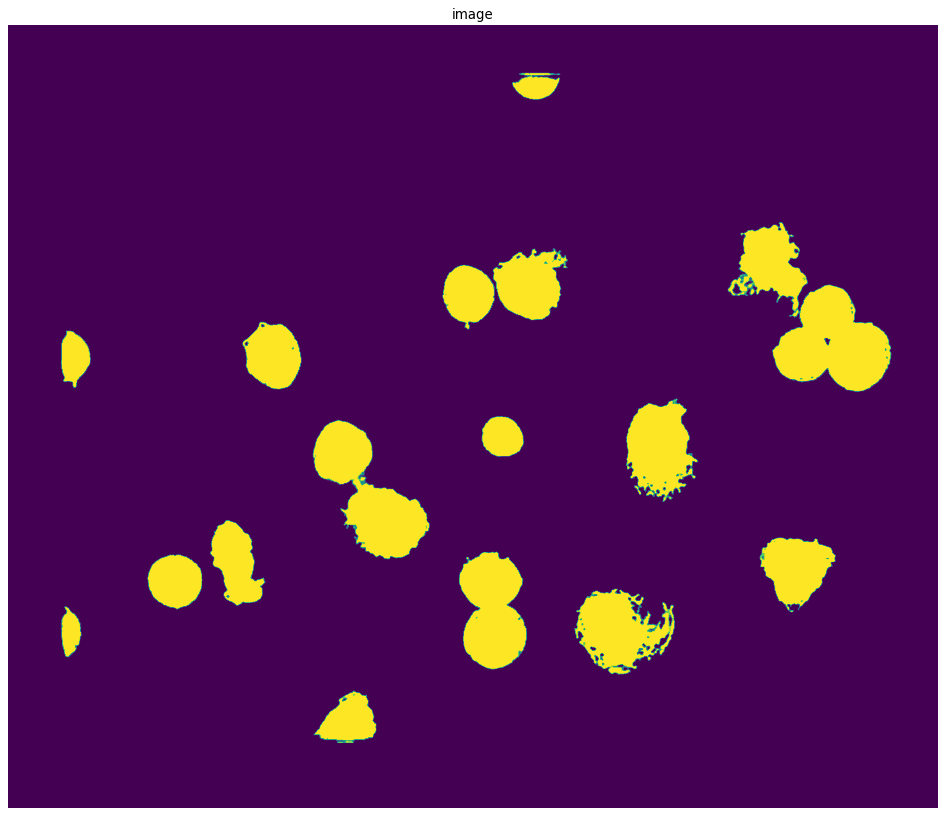

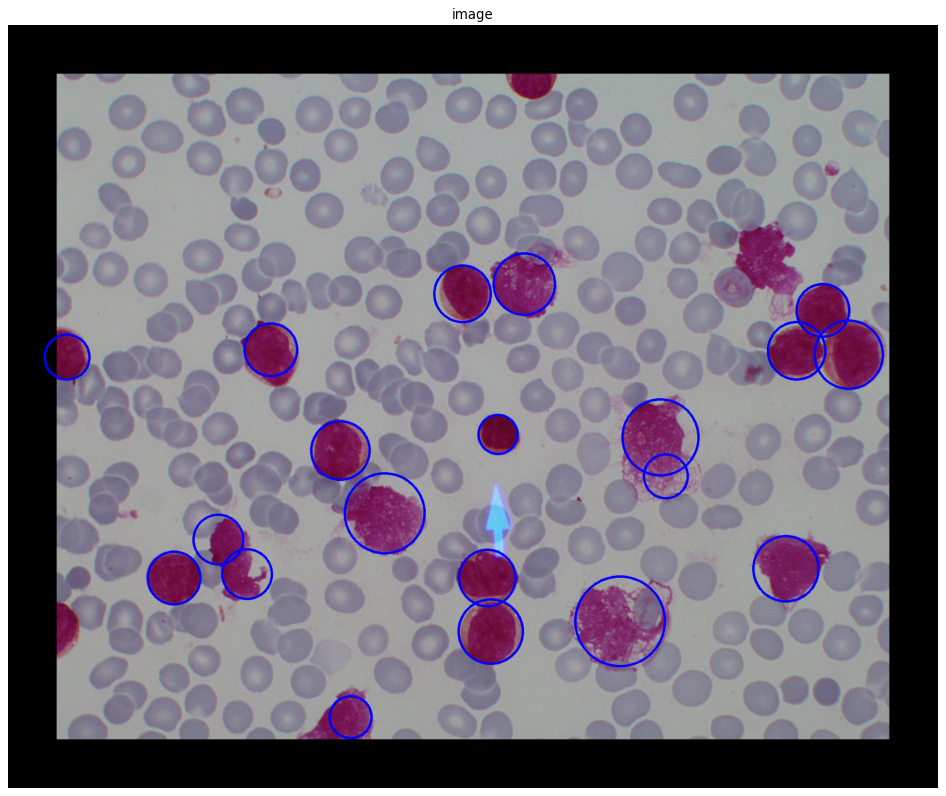

In [11]:
from scripts import postProcessing

original_images = data.load_data_na(images_path, RGB=True, preprocess = True, padding=100)

ind = 1

postProcessing.CHT_Count(original_images[ind], masks[ind], plot=False, min_filter_size=1000, param1 = 500, param2 = 7.6, min_dist=80, threshold = 60)

- Watershed


In [40]:
original_images = data.load_data_na(images_path, RGB=True, preprocess = True, padding=100)

In [41]:
manual_count_file = open("ALL-IDB1_WBC_Count.txt", "r")

manual_count_file_lines = manual_count_file.readlines()
manual_count_file_lines = ''.join(manual_count_file_lines).split("\n")

manual_counts_f = []
manual_counts = []

for line in manual_count_file_lines:
    split = line.split(" ")
    manual_counts_f += [(split[0], split[1])]
    manual_counts += [split[1]]


manual_counts = np.asarray(manual_counts).astype(np.int32)

In [ ]:
watershed_counts = []
for i in range(len(original_images)):
    print(f"counting WBC's in image {images_path[i]}")
    watershed_count = postProcessing.Watershed_Count(original_images[i], masks[i], plot = True, min_filter_size=2000, threshold_type="binary", local_max_min_dist = 70)
    watershed_counts += [watershed_counts]    


counting WBC's in image ALL-IDB1/Im001_1.jpg


In [42]:
print(f"old accuracy : {watershed_accuracy.mean()}")

watershed_accuracy = (1 - (np.abs(np.subtract(manual_counts, watershed_counts))) / manual_counts) * 100

print(f"new accuracy : {watershed_accuracy.mean()}")

old accuracy : 92.09612251790986
new accuracy : 92.09612251790986


In [14]:
from scripts import postProcessing

images_path = sorted(glob.glob(f'ALL-IDB1/*.jpg'))


In [ ]:
postProcessing.WBC_Count(images_path, unet)

In [ ]:
data.plot_ime(images,
              masks,
              masks,
              figSize=(25,15),
              max_plots = 40)

## model training data plot

In [ ]:
hist = history.history

lines = 4
columns = 3

fig = plt.figure(figsize=(20, 20), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask accuracy")
ax.plot(hist['mask_acc'], label="Training")
ax.plot(hist['val_mask_acc'], label="Validation")
ax.legend()
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge mask accuracy")
ax.plot(hist['edge_acc'], label="Training")
ax.plot(hist['val_edge_acc'], label="Validation")
ax.legend()
fig_num = fig_num + 2
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask loss")
ax.plot(hist['mask_loss'], label="Training")
ax.plot(hist['val_mask_loss'], label="Validation")
ax.legend()
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge loss")
ax.plot(hist['edge_loss'], label="Training")
ax.plot(hist['val_edge_loss'], label="Validation")
ax.legend()

fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("global loss")
ax.plot(hist['loss'], label="Training")
ax.plot(hist['val_loss'], label="Validation")
ax.legend()


fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask metrics")
ax.plot(hist['mask_dsc'], label="dsc")
ax.plot(hist['mask_mean_iou'], label="mean iou")
ax.plot(hist['mask_tversky'], label="tversky")
ax.plot(hist['mask_acc'], label="accuracy")

ax.set_title("mask metrics")
ax.plot(hist['val_mask_dsc'], label="val_dsc")
ax.plot(hist['val_mask_mean_iou'], label="val_mean iou")
ax.plot(hist['val_mask_tversky'], label="val_tversky")
ax.plot(hist['val_mask_acc'], label="val_accuracy")

fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge metrics")
ax.plot(hist['edge_dsc'], label="dsc")
ax.plot(hist['edge_mean_iou'], label="mean iou")
ax.plot(hist['edge_tversky'], label="tversky")
ax.plot(hist['edge_acc'], label="accuracy")

ax.set_title("edge metrics")
ax.plot(hist['val_edge_dsc'], label="val_dsc")
ax.plot(hist['val_edge_mean_iou'], label="val_mean iou")
ax.plot(hist['val_edge_tversky'], label="val_tversky")
ax.plot(hist['val_edge_acc'], label="val_accuracy")
ax.legend()